In [31]:
import mysql.connector as connector
import sklearn

In [32]:
conn = connector.connect(user='root', password='123456', host='localhost', port='3306', database='my_db')

mycursor = conn.cursor()

In [33]:
mycursor.execute('show tables')

result =  mycursor.fetchall()


In [34]:
result

[('price_sentiment',), ('stock_price',), ('user',)]

In [35]:
import pandas as pd

mycursor.execute('SELECT * FROM price_sentiment')
result = mycursor.fetchall()
df = pd.DataFrame(result, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Score', 'Positive' , 'Negative', 'Neutral', 'Total_Sentiment'])

In [36]:
df.set_index('Date', drop = True, inplace=True)

In [37]:
date = df.index

In [38]:
df.drop(['Open', 'High', 'Low', 'Dividends', 'Stock_Splits', 'Score', 'Positive',	'Negative',	'Neutral'], inplace=True, axis=1)

In [39]:
df

,Close,Volume,Total_Sentiment
Date,,,
2014-01-06,0.374438,409492000.0,0.00000
2014-04-23,0.452159,261580000.0,-1.00000
2015-06-01,0.541710,372660000.0,0.00000
2016-01-05,0.802491,490272000.0,1.00000
2016-09-28,1.642590,319788000.0,0.00000
...,...,...,...
2025-02-10,133.570000,216989000.0,5.84000
2025-02-11,132.800000,178902000.0,3.90909
2025-02-12,131.140000,160279000.0,4.76471


In [40]:
df['Close'] = df['Close'].shift(-1)

In [41]:
df.dropna(inplace=True)

In [42]:
from sklearn.preprocessing import MinMaxScaler

df_columns = df.columns
scaler = MinMaxScaler()

df_transformed = scaler.fit_transform(df)


In [43]:
df_transformed = pd.DataFrame(df_transformed)

df_transformed.columns = df_columns

df_transformed

,Close,Volume,Total_Sentiment
0,0.000521,0.098819,0.029484
1,0.001122,0.058223,0.000000
2,0.002872,0.088710,0.029484
3,0.008508,0.120991,0.058968
4,0.008610,0.074199,0.029484
...,...,...,...
7932,0.893597,0.049058,0.079607
7933,0.888431,0.045985,0.201671
7934,0.877294,0.035531,0.144740
7935,0.905136,0.030420,0.169967


In [44]:
def traintest(data):

    #X = data.drop(columns=['Close'], axis = 1)
    X= data.drop(['Close'],axis=1)
    Y = data['Close']
    
    X_train = X.iloc[0:int(0.7*len(X))]
    Y_train = Y.iloc[int(len(X))-int(0.7*len(X)):int(len(Y))]
    X_test = X.iloc[0:int(0.7*len(X))]
    Y_test = Y.iloc[int(len(X))-int(0.7*len(X)):int(len(Y))]

    

    return X_train, X_test, Y_train,Y_test


In [45]:
from sklearn.linear_model import LinearRegression

X_train, X_test, Y_train,Y_test = traintest(df_transformed)

model=LinearRegression()

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [46]:
r2 = sklearn.metrics.r2_score(Y_test, y_pred)
print(r2)


0.05473315331364703


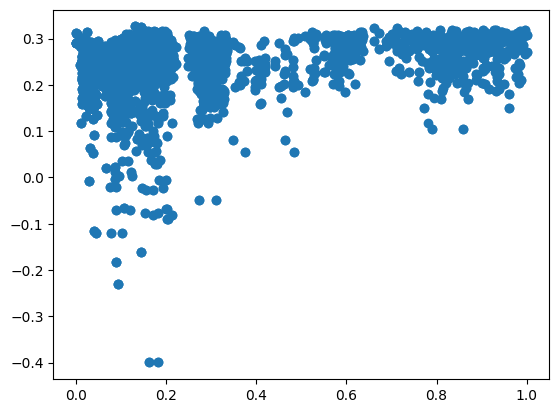

In [47]:
import matplotlib.pyplot as plt

plt.scatter(Y_test, y_pred)

<Axes: >

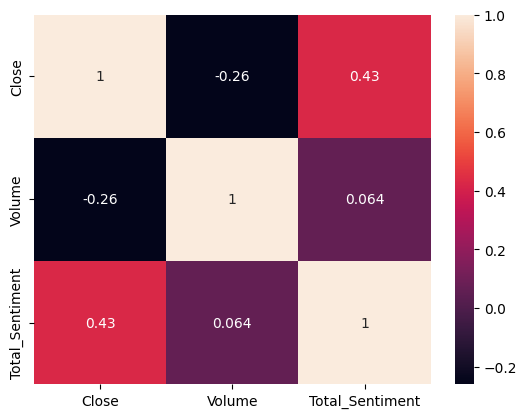

In [48]:
import seaborn as sns 

sns.heatmap(df.corr(), annot= True)

In [49]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

In [50]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6],
    'model__fit_intercept': [True, False]
}

In [51]:
X = df.drop('Close', axis=1)

Y= df['Close']

In [52]:
# 🔹 Perform Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1  # Using R² as the metric
)

grid_search.fit(X, Y)  # Flatten Y to 1D array

print(f"Best Polynomial Degree: {grid_search.best_params_['poly__degree']}")
print(f"Best R² Score: {grid_search.best_score_:.4f}")

Best Polynomial Degree: 1
Best R² Score: 0.2655


## Decision Tree

In [53]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train, Y_train)

y_pred = dt.predict(X_test)

r2 = sklearn.metrics.r2_score(Y_test, y_pred)

print(r2)

0.957324790495076


In [54]:
df_transformed.tail(5)

,Close,Volume,Total_Sentiment
7932,0.893597,0.049058,0.079607
7933,0.888431,0.045985,0.201671
7934,0.877294,0.035531,0.144740
7935,0.905136,0.030420,0.169967
7936,0.929020,0.040616,0.320304


In [ ]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

140.745


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## LSTM (TBC)